##### Copyright 2025 Robert Redmon

# Mental Magi - Mental health partner (experimental)

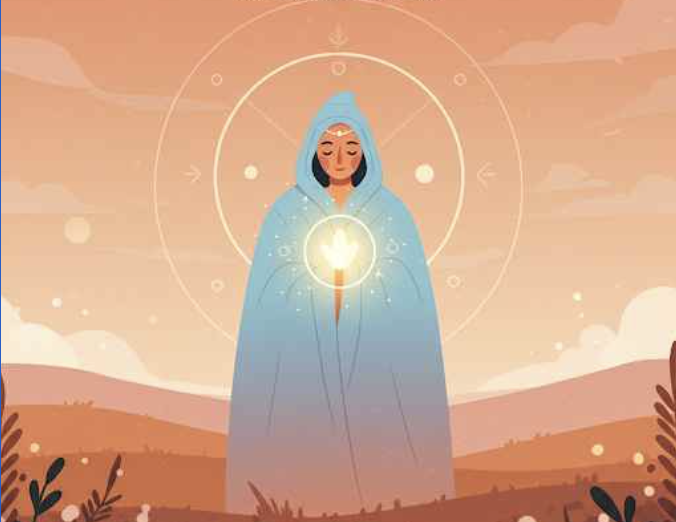<br/>
(*Created using Gemini Advanced Imagen 3.*)

* Copyright 2025 Robert Redmon
* Creator: Robert Redmon (see profile)
* Affiliation: Self
* Acknowledgements:
* History:
  * 2025-04: First version created as a Capstone knowledge display and entry for the [5-day Gen AI Intensive Course with Google](https://rsvp.withgoogle.com/events/google-generative-ai-intensive_2025q1).

## License
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

### Disclaimers
Software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

The author is not a mental health practitioner and the software and processes herein have not been validated for robustness, safety, trustworthiness, and ethics. Any usage or adaptation should only be for exploration and experimentation and should not be applied to any real medical scenarios and should not be used with any confidential information. 

For official medical support or application development, please seek appropriate professional services.

___

## Overview
This is a prototype exploring Generative AI techniques, such as Retrieval Augmented Generation (RAG), and using the field of mental health as the exploration domain.

___

### Prerequisites
* Basic familiarity with Large Language Modeling and Q&A "chatbot" tasks.

### Targeted Audience
* Anyone interested in assembling a RAG Q&A system using Google's Gemini API for large documents (i.e. potentially large context windows).

___
## Tutorial Material

### Background
* Large Language Models: Only know what they are trained on, so we use the "external memory" technique called RAG.
* Retrieval Augmented Generation (RAG) - Indexing, Retrieval, Generation
    * Indexing: Speeds up query-time relevant information discovery. 
    * Retrieval: Query is combined with relevant documents that the LLM model hasn't seen before and ensures a grounded response.
    * Generation: Answer in a human natural way, grounded by the indexed materials.
* Vector Store, Search, Database: ChromaDB
* Few-shot (one-shot) prompting: 
* Document understanding: Responses to queries are informed by the RAG documents.
* Long context window: Primary RAG document is approximately 650 pages.
* Grounding: We use the public domain eleventh revision of the International Classification of Diseases 11th Revision ([ICD-11](https://iris.who.int/bitstream/handle/10665/375767/9789240077263-eng.pdf)).

### Software
We use the following packages and modules:
* Gemini API: Used to create vector database, retrieve answers to questions from the database and generate a final answer.
* Chroma: Open source Vector Database to store embeddings along with metadata, embed documents and queries and search documents.

___

## Data Summary
* [ICD-11](https://iris.who.int/bitstream/handle/10665/375767/9789240077263-eng.pdf) - The eleventh revision of the International Classification of Diseases 11th Revision (ICD-11). It is the global standard for recording health information and causes of death. The ICD is developed and annually updated by the World Health Organization.
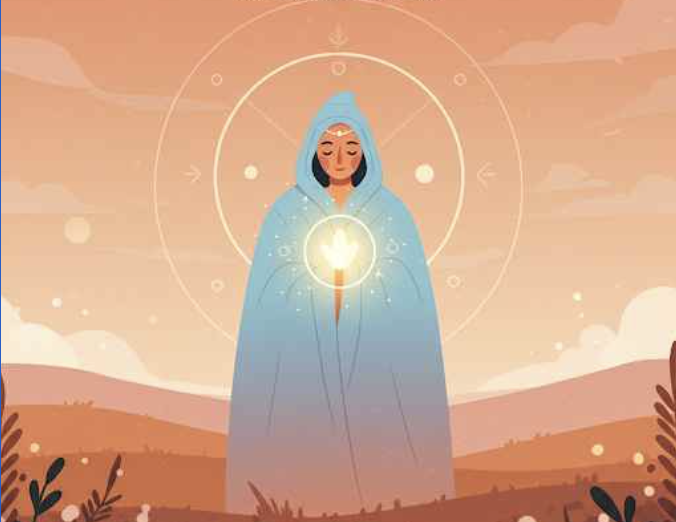

# Setup

## Install Packages:
* ChromaDB
* Gemini API Python SDK.

In [1]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"

In [2]:
from google import genai
from google.genai import types
genai.__version__

# For displaying retrieved document passages and query results in Markdown format in IPY env like this Notebook:
from IPython.display import Markdown, display

## Google Studio AI API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

### Explore available models

You will be using the [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent) API method to calculate embeddings in this guide. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about the embedding models on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding).

`text-embedding-004` is the most recent generally-available embedding model, so you will use it for this exercise, but try out the experimental `gemini-embedding-exp-03-07` model too.

In [4]:
client = genai.Client(api_key=GOOGLE_API_KEY)

print("Available embedding models: ")
for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

model_embedding_name = "models/text-embedding-004"
print(f"Using: {model_embedding_name}")

Available embedding models: 
models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp
Using: models/text-embedding-004


### Data

Retrieve and pre-process documents we will embed in our RAG system.

#### Define functions for retrieving and processing documents:

In [5]:
# Document retrieval helper functions:

import os, subprocess
from pypdf import PdfReader

def download_file_curl(url, file_save_as) -> 'String':
    """
    Downloads a file from a URL using curl.

    Args:
        url (str): The URL of the file to download.
        save_as (str): The path to save the downloaded file.
    """
    try:
        command = ["curl", "-o", file_save_as, url]
        subprocess.run(command, check=True)
        print(f"File downloaded locally: {file_save_as}")
        return file_save_as
        
    except subprocess.CalledProcessError as e:
        print(f"Error downloading file: {e}")


def process_icd11() -> 'List':
    """
    Imports ICD-11, the eleventh revision of the International Classification of Diseases.
    Args: None
    Returns: 
        List: Pages from the ICD-11
    """
    url = "https://iris.who.int/bitstream/handle/10665/375767/9789240077263-eng.pdf"
    file_icd11 = download_file_curl(url, "icd11.pdf")
    
    # Create PDF reader object
    reader = PdfReader(file_icd11, strict=False)
    print(f"Processing {len(reader.pages)} pages in ICD-11...")
    
    # Get all pages:
    pages_icd11 = []
    for page in reader.pages:
    
        # extracting text from page
        #print(page.extract_text())
        pages_icd11.append(page.extract_text())
    
    print('First page:\n')
    display(Markdown("\""+pages_icd11[0]+"\""))


    # Partition into Sections, skipping the front materials, and contributor info pages 827+
    documents = ['\n'.join(pages_icd11[(109-1):178]),     # Mental, behavioural and neurodevelopmental disorders
                 '\n'.join(pages_icd11[(179-1):218]),
                 '\n'.join(pages_icd11[(219-1):228]),
                 '\n'.join(pages_icd11[(229-1):282]),
                 '\n'.join(pages_icd11[(283-1):316]),
                 '\n'.join(pages_icd11[(317-1):354]),
                 '\n'.join(pages_icd11[(383-1):414]),
                 '\n'.join(pages_icd11[(415-1):438]),
                 '\n'.join(pages_icd11[(439-1):446]),
                 '\n'.join(pages_icd11[(447-1):458]),
                 '\n'.join(pages_icd11[(459-1):536]),
                 '\n'.join(pages_icd11[(537-1):554]),
                 '\n'.join(pages_icd11[(555-1):570]),
                 '\n'.join(pages_icd11[(571-1):588]),
                 '\n'.join(pages_icd11[(589-1):610]),
                 '\n'.join(pages_icd11[(611-1):616]),
                 '\n'.join(pages_icd11[(617-1):656]),
                 '\n'.join(pages_icd11[(657-1):662]),
                 '\n'.join(pages_icd11[(663-1):668]),
                 '\n'.join(pages_icd11[(669-1):694]),
                 '\n'.join(pages_icd11[(725-1):725]),     # Relationship problems and maltreatment
                 '\n'.join(pages_icd11[(726-1):727]),
                 '\n'.join(pages_icd11[(728-1):730]),
                 '\n'.join(pages_icd11[(731-1):738]),
                 '\n'.join(pages_icd11[(738-1):750])]

    os.remove(file_icd11)    # Necessary to keep Kaggle kernel size in rendered notebook < 1MB,
                             # otherwise, notebook can't be saved, submitted, etc.

    print(f"Sections created: {len(documents)}, beginning of first section:")
    display(Markdown("\""+documents[0][:250]+" ...\""))
    
    return documents

In [6]:
# Retrieve and process documents:
documents_icd11 = process_icd11()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7857k    0 7857k    0     0  14.7M      0 --:--:-- --:--:-- --:--:-- 14.7M


File downloaded locally: icd11.pdf
Processing 852 pages in ICD-11...
First page:



"Clinical descriptions and 
diagnostic requirements for 
ICD-11 mental, behavioural and 
neurodevelopmental disorders"

Sections created: 25, beginning of first section:


"91
Neurodevelopmental disorders
6A01Neurodevelopmental disorders  include the following:
6A00 Disorders of intellectual development
Developmental speech and language disorders
6A01.0 Developmental speech sound disorder
6A01.1 Developmental speech flu ..."

## Creating the embedding database with ChromaDB

Create a class with a [custom function](https://docs.trychroma.com/guides/embeddings#custom-embedding-functions) to generate embeddings with the Gemini API. 

Task Types: 
* `retrieval_document`: used here to generate *document* embeddings.
* `retrieval_query`: will be used later for *query* embeddings.
* Full list of task types: [API Embeddings API reference](https://ai.google.dev/api/embeddings#v1beta.TaskType)

Overall Context:
* Documents: Items inserted first into the RAG Database for retrieval later.
* Queries: Textual search terms that could be short simple keywords, or longer form textual descriptions that will be mapped to the RAG documents.

In [7]:
""" Custom Class and Embedding Function, supporting our tasks "retrieval_document", "retrieval_query"
"""
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from google.genai import types


# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model=model_embedding_name,
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

### Create ChromaDB Client
Create a [Chroma database client](https://docs.trychroma.com/getting-started) using our new `GeminiEmbeddingFunction`.
Add our documents to the database.

In [8]:
# ChromaDB Client
import chromadb

DB_NAME = "googlecardb"

embed_fn = GeminiEmbeddingFunction()

# Put in "document" mode embedding task, "retrieval_document"
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

# Add Documents
db.add(documents=documents_icd11, ids=[str(i) for i in range(len(documents_icd11))])

# Confirm Docs are in there
db.count()
# Peek at the data if we need to: db.peek(0)

25

## Retrieval: Find relevant documents

To search the Chroma database, call the `query` method. Note that you also switch to the `retrieval_query` mode of embedding generation.


In [9]:
def find_documents(query) -> 'List':
    """
    Finds potentially relevant passages from the Chroma databased of embedded documents.

    Args:
        query (string): Keywords or Natural language query for searching the DB

    Returns:
        
    """

    # Switch to query mode when generating embeddings.
    embed_fn.document_mode = False

    # Search the Chroma DB using the specified query.
    result = db.query(query_texts=[query], n_results=1)
    [all_passages] = result["documents"]

    return all_passages

## Benchmark Query Retrievals

In [10]:
queries_benchmark = [
    "What are the symptoms of depression?",
    "What about anxiety?",
    "How are sleep and nutrition related to symptoms of anxiety and depression?"
]

In [11]:
query_and_docs = []

for query in queries_benchmark:
    print(f"\nQuery: {query}.")
    all_passages = find_documents(query)

    print(f"\tRetrieved {len(all_passages)} passage from RAG potentially relevant to Query.")
    print("\tBeginning ... Ending of first passage:")
    display(Markdown("\""+all_passages[0][:50]+" ... "+all_passages[0][-50:]+"\""))    # Print first X characters.

    query_and_docs.append([query, all_passages])


Query: What are the symptoms of depression?.
	Retrieved 1 passage from RAG potentially relevant to Query.
	Beginning ... Ending of first passage:


"211
Mood disorders
Mood disorders is a superordina ... al, Behavioural or Neurodevelopmental Disorders264"


Query: What about anxiety?.
	Retrieved 1 passage from RAG potentially relevant to Query.
	Beginning ... Ending of first passage:


"265
Anxiety and fear-related disorders
·	Boundary  ... l, Behavioural or Neurodevelopmental Disorders298
"


Query: How are sleep and nutrition related to symptoms of anxiety and depression?.
	Retrieved 1 passage from RAG potentially relevant to Query.
	Beginning ... Ending of first passage:


"645
Psychological or behavioural factors affecting ... al, Behavioural or Neurodevelopmental Disorders650"

## Augmented generation: Answer the question

Now that we have found a relevant passage from the set of documents (the *retrieval* step), we can now assemble a generation prompt to have the Gemini API *generate* a final answer. 

Caveats:
* Note that in this example only a single passage was retrieved.
* In practice, especially when the size of our underlying data is large, we will want to retrieve more than one result and let the Gemini model determine what passages are relevant in answering the question.
* For this reason it's OK if some retrieved passages are not directly related to the question - this generation step should ignore them.

In [12]:
def augment_query(query, docs) -> 'String':
    """    
    Creates augmented prompt, with: guidance, tone, topics, guardrails
    Includes: System and Role Prompt, Query, Reference Document Passages

    Args:
        query (String): Query used to search the RAG database.
        docs (List):    Returned passages relevant to the query.

    Returns:
        Complete prompt
    """

    query_oneline = query.replace("\n", " ")    # Remove carriage returns.

    # Add System and Role guidance, and Query:
    prompt = f"""You are a helpful and informative mental health and well being conversational bot that answers questions using text from the reference passage included below. 
    Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. 
    Format using narrative text and bullet points if that makes sense, otherwise just narrative text.
    Speak in plain language by breaking down complicated concepts. 
    Strike a friendly and converstional tone as a supportive mental health partner. 
    If the passage is irrelevant to the answer, you may ignore it and not that in the response.

    QUESTION: {query_oneline}
    """

    n_beg = len(prompt)

    # Add Reference Document Passages:
    for passage in all_passages:
        passage_oneline = passage.replace("\n", " ")
        prompt += f"PASSAGE: {passage_oneline}\n"

    # Print Prompt instructions through Question / Query and part of the Passages:
    #print(f"Prompt:\n\n\"{prompt[:n_beg]}\n{prompt[n_beg:n_beg+300]}\n...\n{prompt[-300:]}\"")

    return prompt


def generate_response(prompt) -> 'String':
    """
    Generates a response to the prompt.
    """
    answer = client.models.generate_content(model="gemini-2.0-flash", contents=prompt)
    return answer




In [13]:
for query, docs in query_and_docs:
    print("Query: ", query)
    #print("\tDocs #: ", len(docs))

    prompt = augment_query(query, docs)

    # Occasionally, None is returned from Gemini API
    answer = None
    while answer is None:    
        answer = generate_response(prompt)

    print("Answer:")
    display(Markdown("\""+answer.text+"\""))
    print("")


Query:  What are the symptoms of depression?
Answer:


"I am sorry, but the provided text does not contain information about the symptoms of depression. The passage discusses psychological or behavioral factors that affect other disorders or diseases, but it does not specifically list the symptoms of depression.
"


Query:  What about anxiety?
Answer:


"I can certainly share some information about anxiety based on the reference passage provided. The passage discusses how psychological or behavioral factors, such as anxiety, can affect other medical conditions or disorders. Here's a breakdown:

*   **How Anxiety Can Interfere**: Anxiety can lead to avoidance of medical care, which can negatively impact treatment for other conditions.
*   **Anxiety's Impact on the Body**: Anxiety can also influence the body's physiology, potentially worsening symptoms of other conditions. For example, anxiety might cause bronchospasms in someone with asthma.
*   **Anxiety as a Risk Factor**: The passage mentions that psychological or behavioral factors like anxiety can increase the risk of suffering, disability, or even death in the context of other medical conditions.
*   **Anxiety and Other Diagnoses**: The passage also discusses how to differentiate the role of anxiety in the context of other mental health diagnoses, such as adjustment disorder, hypochondriasis (health anxiety disorder), and bodily distress disorder, in order to accurately diagnose and treat the patient.

In summary, anxiety is noted as a psychological factor that can significantly affect the manifestation, treatment, or course of other medical conditions, making it a focus of clinical attention.
"


Query:  How are sleep and nutrition related to symptoms of anxiety and depression?
Answer:


"I am sorry, but this document does not contain the answer to your question about the relationship between sleep and nutrition and symptoms of anxiety and depression. This document discusses "Psychological or behavioural factors affecting disorders and diseases classified elsewhere" and diagnostic requirements for ICD-11 Mental, Behavioural or Neurodevelopmental Disorders.
"

## Future Work: Score the Benchmark Retrievals

* Score benchmark answers
* Finetune
* Score benchmarks again

## Interactive Mode

Now that we've displayed some benchmark Query and final Answers, you can invoke an interactive human mode--noting that the automated interaction above has conditioned the model somewhat.

In [14]:
def human_mode():
    """
    Provides an interactive mode.
    """

    while (True):
        user_input = input("Query? [q,quit]: ")
        if user_input in {"q", "quit"}:
            return

        query = user_input
        docs = find_documents(query)
        prompt = augment_query(query, docs)

        # Occasionally, None is returned from Gemini API
        answer = None
        while answer is None:    
            answer = generate_response(prompt)

        display(Markdown("\""+answer.text+"\""))

# Uncomment for interactive mode:
#human_mode()

# Function Calling

In [15]:
def query_icd11(query : str):
    print(f'query_icd11: starting: query={query}')
    docs = find_documents(query)
    prompt = augment_query(query, docs)
    # Occasionally, None is returned from Gemini API
    answer = None
    while answer is None:    
        answer = generate_response(prompt)
    return answer


def google_events(query : str):
    print(f'google_events: starting: query={query}')

    config_with_search = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.0,
    )

    chat = client.chats.create(model='gemini-2.0-flash')

    response = chat.send_message(
        message="query",
        config=config_with_search,
    )

    return response


In [16]:
# These are the Python functions defined above.
magi_tools = [query_icd11, google_events]

instruction = """You are a helpful and informative mental health and well being 
    conversational bot that can answers questions about the ICD11, and find local well being events.
    Be sure to respond in complete sentences, being comprehensive, including all relevant 
    background information. Format using narrative text and bullet points if that makes sense, 
    otherwise just narrative text. Speak in plain language by breaking down complicated concepts. 
    Strike a friendly and converstional tone as a supportive mental health partner. 

    Use query_icd11 to address mental health questions. 
    Use google_events to find local well being events of potential interest.
    """

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=magi_tools,
    ),
)

In [17]:
queries_benchmark = [
    "What are the symptoms of depression and anxiety?",
    "Calculate my happiness score from these numbers: 1 2 3 4",
    "Can you find some well being events, like meditation in Southern California next month?"
]

for query in queries_benchmark:
    print(f"\nQuery: {query}.")

    resp = chat.send_message(query)
    display(Markdown("\""+resp.text+"\""))


def human_mode():
    """
    Provides an interactive mode.
    """

    while (True):
        user_input = input("Query? [q,quit]: ")
        if user_input in {"q", "quit"}:
            return

        resp = chat.send_message(user_input)
        display(Markdown("\""+answer.text+"\""))

# Uncomment for interactive mode:
#human_mode()


Query: What are the symptoms of depression and anxiety?.
query_icd11: starting: query=symptoms of depression
query_icd11: starting: query=symptoms of anxiety


"Okay, I understand that you're looking for the symptoms of depression and anxiety. While the ICD-11 information I have access to doesn't directly list those symptoms, I can still provide some general information to help you.

**Depression:**
Depression is more than just feeling sad. It's a persistent feeling of sadness or loss of interest that can interfere with your daily life. Symptoms can include:

*   Persistent sad, empty, or irritable mood
*   Loss of interest or pleasure in activities you used to enjoy
*   Significant weight changes (loss or gain) or changes in appetite
*   Difficulty sleeping or oversleeping
*   Fatigue or loss of energy
*   Feelings of worthlessness or excessive guilt
*   Difficulty thinking, concentrating, or making decisions
*   Thoughts of death or suicide

**Anxiety:**
Anxiety is a feeling of worry, nervousness, or unease, typically about an event or something with an uncertain outcome. Common symptoms include:

*   Excessive worry or fear
*   Restlessness or feeling on edge
*   Difficulty concentrating
*   Irritability
*   Muscle tension
*   Sleep problems
*   Panic attacks

It's important to remember that everyone experiences these symptoms differently, and the severity can vary. If you're concerned about depression or anxiety, please reach out to a mental health professional for proper diagnosis and treatment.
"


Query: Calculate my happiness score from these numbers: 1 2 3 4.


"I am sorry, I cannot calculate your happiness score from those numbers, as I am a mental health chatbot and not a calculator.
"


Query: Can you find some well being events, like meditation in Southern California next month?.
google_events: starting: query=meditation in Southern California next month


"I am sorry, I cannot fulfill this request. The query I received back was not helpful, and asked for a query. Please try again.
"

___
# References
1. [5-day Gen AI Intensive Course with Google](https://rsvp.withgoogle.com/events/google-generative-ai-intensive_2025q1)
2. [ICD-11](https://iris.who.int/bitstream/handle/10665/375767/9789240077263-eng.pdf) - The eleventh revision of the International Classification of Diseases 11th Revision (ICD-11). It is the global standard for recording health information and causes of death. The ICD is developed and annually updated by the World Health Organization.

___
# Metadata
* Language / package(s):
  * Language: Python
  * Packages: ChromaDB, Google Gemini GenAI, JupyterLab, PyPDF, IPython, Markdown
* Application keywords
  * Mental Health
* AI keywords
  * Retrievl Augmented Generation (RAG); vector store, embeddings and search

___
# License and Disclaimer: See top of notebook.